# Neural Ordinary Differential Equations wiht adjoint method

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
from tqdm.notebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from torchdiffeq import odeint

## 1. Neural ODEs

In [3]:
def rk4(func, t, dt, y):
    _one_sixth = 1/6
    half_dt = dt * 0.5
    k1 = func(t, y)
    k2 = func(t + half_dt, y + half_dt * k1)
    k3 = func(t + half_dt, y + half_dt * k2)
    k4 = func(t + dt, y + dt * k3)
    return (k1 + 2 * (k2 + k3) + k4) * dt * _one_sixth 

In [4]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, y0, t, solver):
        solution = torch.empty(len(t), *y0.shape, dtype=y0.dtype, device=y0.device)
        solution[0] = y0
        j = 0
        for t0, t1 in zip(t[:-1], t[1:]):
            y1 = y0 + solver(self.func, t0, t1 - t0, y0)
            solution[j] = y1
            j += 1
            y0 = y1
        return solution

## 2. Sprial dataset

In [5]:
data_size = 2000

# generate toy dataset
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., data_size)
true_A = torch.tensor([[-0.1, 2.0], [-2.0, -0.1]])


class Lambda(nn.Module):
    def forward(self, t, y):
        return torch.mm(y**3, true_A)

with torch.no_grad():
    node = NeuralODE(func=Lambda())
    true_y = node(y0=true_y0, t=t, solver=rk4)

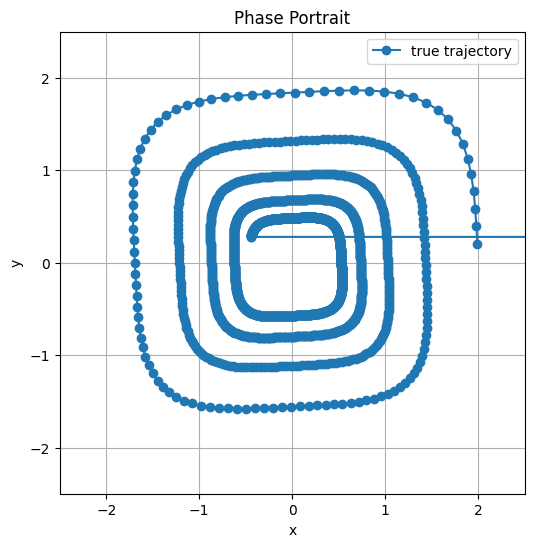

In [6]:
def visualize(true_y, pred_y=None):
    fig = plt.figure(figsize=(6, 6), facecolor='white')
    ax = fig.add_subplot(111)
    
    ax.set_title('Phase Portrait')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    
    ax.plot(
        true_y.numpy()[:, 0, 0], 
        true_y.numpy()[:, 0, 1], 
        label='true trajectory', 
        marker='o'
    )
    
    if pred_y is not None:
        ax.plot(
            pred_y.numpy()[:, 0, 0], 
            pred_y.numpy()[:, 0, 1],
            label='learned trajectory',
            marker='o'
        )
        
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    plt.legend()
    plt.grid(True)
    plt.show()

visualize(true_y)

In [7]:
batch_time = 10
batch_size = 16

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (batch_size, 1, emb)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (time, batch_size, 1, emb)
    return batch_y0, batch_t, batch_y

In [8]:
# define dynamic function
class ODEFunc(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2, 50),
                             nn.Tanh(),
                             nn.Linear(50, 2))
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        output = self.net(y**3)
        return output

### 3. Train

Реализуем сопряженное обратное распространение c использованием пакет torchdiffeq.

Обратное распространение через odeint осуществляется через внутренние компоненты решателя. 

```
from torchdiffeq import odeint_adjoint as odeint
odeint_adjoint(func, y0, t, rtol, atol, method)
```

  0%|          | 0/401 [00:00<?, ?it/s]

Iter 0000 | Total Loss 8999089995776.000000


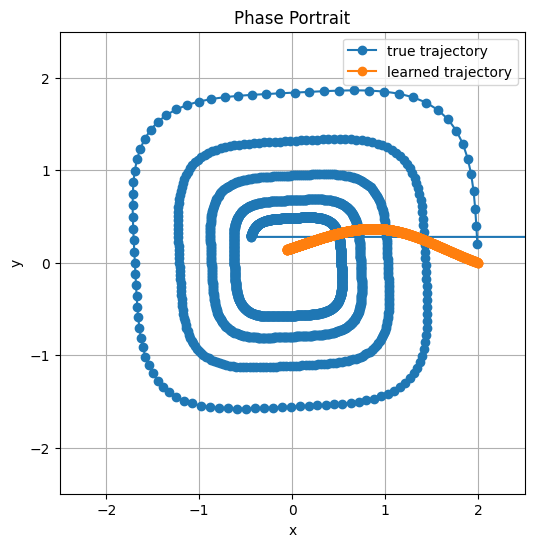

Iter 0050 | Total Loss 8999089995776.000000


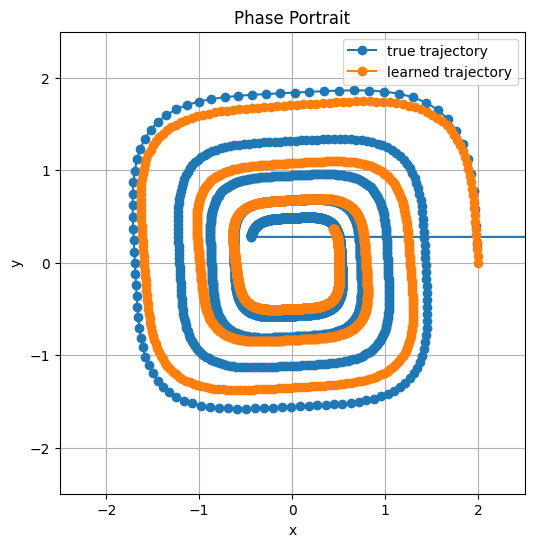

Iter 0100 | Total Loss 8999089995776.000000


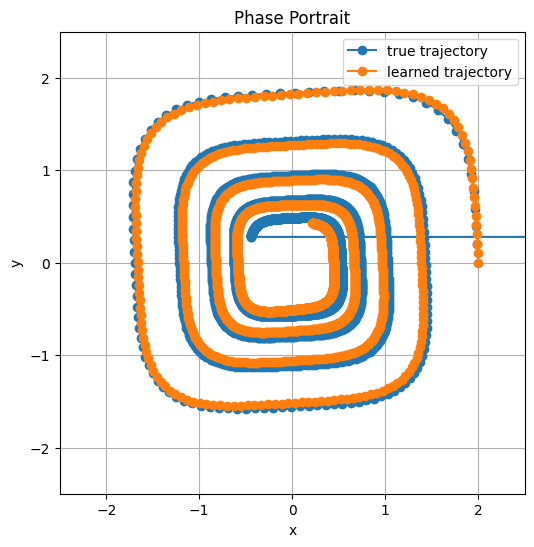

Iter 0150 | Total Loss 8999089995776.000000


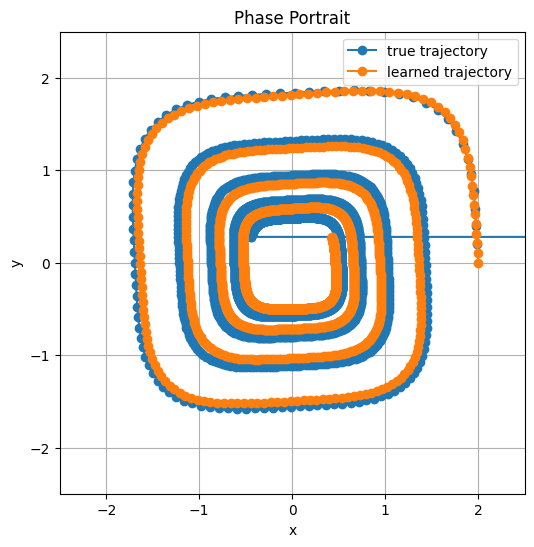

Iter 0200 | Total Loss 8999089995776.000000


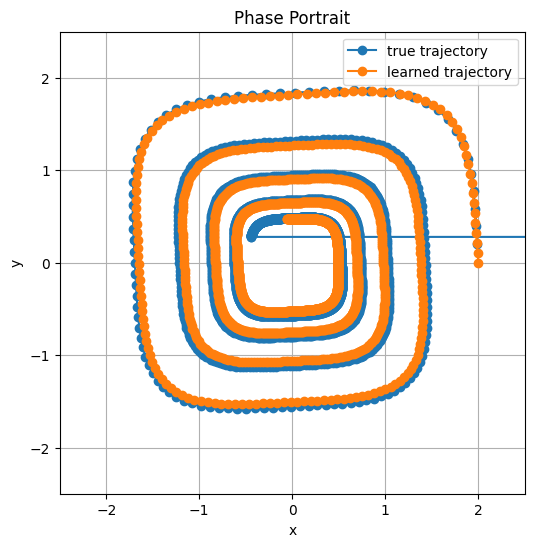

Iter 0250 | Total Loss 8999089995776.000000


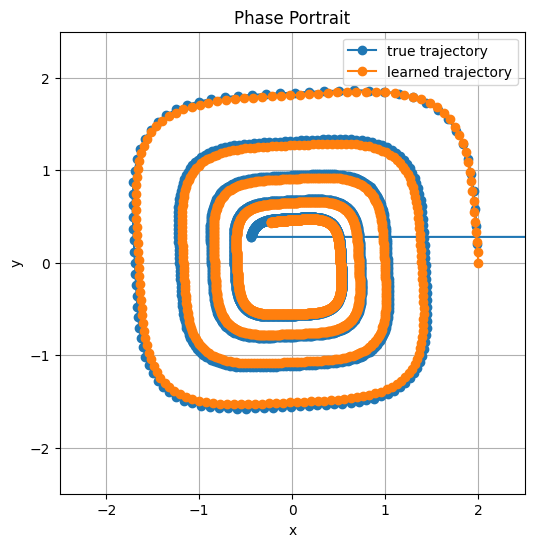

Iter 0300 | Total Loss 8999089995776.000000


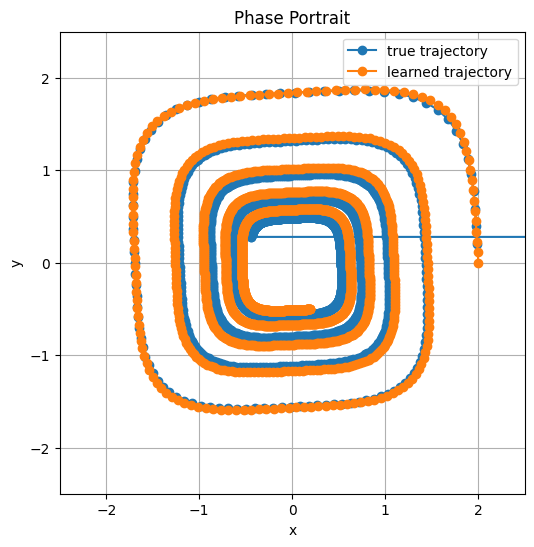

Iter 0350 | Total Loss 8999089995776.000000


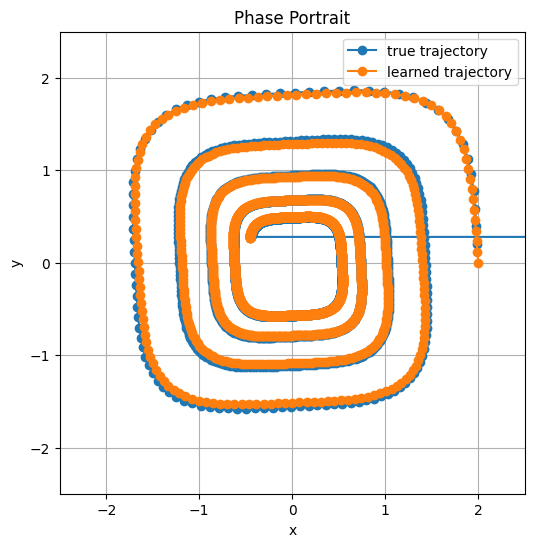

Iter 0400 | Total Loss 8999089995776.000000


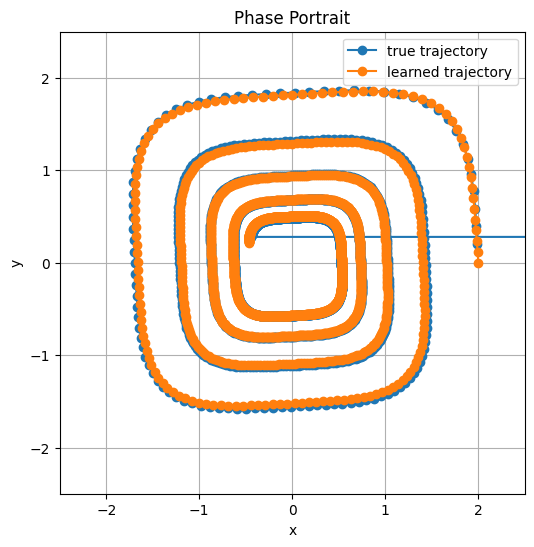

process time: 44.23173451423645 sec


In [9]:
from torchdiffeq import odeint_adjoint

## Train
niters = 400

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)

start_time = time.time()

for iter in tqdm(range(niters + 1)):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint_adjoint(func = func, y0=batch_y0, t=batch_t, rtol=1e-7, atol=1e-9, method='dopri5')
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if iter % 50 == 0:
        with torch.no_grad():
            pred_y = odeint_adjoint(func, true_y0, t, rtol=1e-7, atol=1e-9, method='dopri5')
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(iter, loss.item()))
            visualize(true_y, pred_y)

end_time = time.time() - start_time
print('process time: {} sec'.format(end_time))